In [2]:
import zipfile
with zipfile.ZipFile('datasets.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [3]:
import json
from os import path as osp

import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils import data
from torchvision import transforms


class VITONDataset(data.Dataset):
    def __init__(self, opt):
        super(VITONDataset, self).__init__()
        self.load_height = opt.load_height
        self.load_width = opt.load_width
        self.semantic_nc = opt.semantic_nc
        self.data_path = osp.join(opt.dataset_dir, opt.dataset_mode)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        # load data list
        img_names = []
        c_names = []
        with open(osp.join(opt.dataset_dir, opt.dataset_list), 'r') as f:
            for line in f.readlines():
                img_name, c_name = line.strip().split()
                img_names.append(img_name)
                c_names.append(c_name)

        self.img_names = img_names
        self.c_names = dict()
        self.c_names['unpaired'] = c_names

    def get_parse_agnostic(self, parse, pose_data):
        parse_array = np.array(parse)
        parse_upper = ((parse_array == 5).astype(np.float32) +
                       (parse_array == 6).astype(np.float32) +
                       (parse_array == 7).astype(np.float32))
        parse_neck = (parse_array == 10).astype(np.float32)

        r = 10
        agnostic = parse.copy()

        # mask arms
        for parse_id, pose_ids in [(14, [2, 5, 6, 7]), (15, [5, 2, 3, 4])]:
            mask_arm = Image.new('L', (self.load_width, self.load_height), 'black')
            mask_arm_draw = ImageDraw.Draw(mask_arm)
            i_prev = pose_ids[0]
            for i in pose_ids[1:]:
                if (pose_data[i_prev, 0] == 0.0 and pose_data[i_prev, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                    continue
                mask_arm_draw.line([tuple(pose_data[j]) for j in [i_prev, i]], 'white', width=r*10)
                pointx, pointy = pose_data[i]
                radius = r*4 if i == pose_ids[-1] else r*15
                mask_arm_draw.ellipse((pointx-radius, pointy-radius, pointx+radius, pointy+radius), 'white', 'white')
                i_prev = i
            parse_arm = (np.array(mask_arm) / 255) * (parse_array == parse_id).astype(np.float32)
            agnostic.paste(0, None, Image.fromarray(np.uint8(parse_arm * 255), 'L'))

        # mask torso & neck
        agnostic.paste(0, None, Image.fromarray(np.uint8(parse_upper * 255), 'L'))
        agnostic.paste(0, None, Image.fromarray(np.uint8(parse_neck * 255), 'L'))

        return agnostic

    def get_img_agnostic(self, img, parse, pose_data):
        parse_array = np.array(parse)
        parse_head = ((parse_array == 4).astype(np.float32) +
                      (parse_array == 13).astype(np.float32))
        parse_lower = ((parse_array == 9).astype(np.float32) +
                       (parse_array == 12).astype(np.float32) +
                       (parse_array == 16).astype(np.float32) +
                       (parse_array == 17).astype(np.float32) +
                       (parse_array == 18).astype(np.float32) +
                       (parse_array == 19).astype(np.float32))

        r = 20
        agnostic = img.copy()
        agnostic_draw = ImageDraw.Draw(agnostic)

        length_a = np.linalg.norm(pose_data[5] - pose_data[2])
        length_b = np.linalg.norm(pose_data[12] - pose_data[9])
        point = (pose_data[9] + pose_data[12]) / 2
        pose_data[9] = point + (pose_data[9] - point) / length_b * length_a
        pose_data[12] = point + (pose_data[12] - point) / length_b * length_a

        # mask arms
        agnostic_draw.line([tuple(pose_data[i]) for i in [2, 5]], 'gray', width=r*10)
        for i in [2, 5]:
            pointx, pointy = pose_data[i]
            agnostic_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'gray', 'gray')
        for i in [3, 4, 6, 7]:
            if (pose_data[i - 1, 0] == 0.0 and pose_data[i - 1, 1] == 0.0) or (pose_data[i, 0] == 0.0 and pose_data[i, 1] == 0.0):
                continue
            agnostic_draw.line([tuple(pose_data[j]) for j in [i - 1, i]], 'gray', width=r*10)
            pointx, pointy = pose_data[i]
            agnostic_draw.ellipse((pointx-r*5, pointy-r*5, pointx+r*5, pointy+r*5), 'gray', 'gray')

        # mask torso
        for i in [9, 12]:
            pointx, pointy = pose_data[i]
            agnostic_draw.ellipse((pointx-r*3, pointy-r*6, pointx+r*3, pointy+r*6), 'gray', 'gray')
        agnostic_draw.line([tuple(pose_data[i]) for i in [2, 9]], 'gray', width=r*6)
        agnostic_draw.line([tuple(pose_data[i]) for i in [5, 12]], 'gray', width=r*6)
        agnostic_draw.line([tuple(pose_data[i]) for i in [9, 12]], 'gray', width=r*12)
        agnostic_draw.polygon([tuple(pose_data[i]) for i in [2, 5, 12, 9]], 'gray', 'gray')

        # mask neck
        pointx, pointy = pose_data[1]
        agnostic_draw.rectangle((pointx-r*7, pointy-r*7, pointx+r*7, pointy+r*7), 'gray', 'gray')
        agnostic.paste(img, None, Image.fromarray(np.uint8(parse_head * 255), 'L'))
        agnostic.paste(img, None, Image.fromarray(np.uint8(parse_lower * 255), 'L'))

        return agnostic

    def __getitem__(self, index):
        img_name = self.img_names[index]
        c_name = {}
        c = {}
        cm = {}
        for key in self.c_names:
            c_name[key] = self.c_names[key][index]
            c[key] = Image.open(osp.join(self.data_path, 'cloth', c_name[key])).convert('RGB')
            c[key] = transforms.Resize(self.load_width, interpolation=2)(c[key])
            cm[key] = Image.open(osp.join(self.data_path, 'cloth-mask', c_name[key]))
            cm[key] = transforms.Resize(self.load_width, interpolation=0)(cm[key])

            c[key] = self.transform(c[key])  # [-1,1]
            cm_array = np.array(cm[key])
            cm_array = (cm_array >= 128).astype(np.float32)
            cm[key] = torch.from_numpy(cm_array)  # [0,1]
            cm[key].unsqueeze_(0)

        # load pose image
        pose_name = img_name.replace('.jpg', '_rendered.png')
        pose_rgb = Image.open(osp.join(self.data_path, 'openpose-img', pose_name))
        pose_rgb = transforms.Resize(self.load_width, interpolation=2)(pose_rgb)
        pose_rgb = self.transform(pose_rgb)  # [-1,1]

        pose_name = img_name.replace('.jpg', '_keypoints.json')
        with open(osp.join(self.data_path, 'openpose-json', pose_name), 'r') as f:
            pose_label = json.load(f)
            pose_data = pose_label['people'][0]['pose_keypoints_2d']
            pose_data = np.array(pose_data)
            pose_data = pose_data.reshape((-1, 3))[:, :2]

        # load parsing image
        parse_name = img_name.replace('.jpg', '.png')
        parse = Image.open(osp.join(self.data_path, 'image-parse', parse_name))
        parse = transforms.Resize(self.load_width, interpolation=0)(parse)
        parse_agnostic = self.get_parse_agnostic(parse, pose_data)
        parse_agnostic = torch.from_numpy(np.array(parse_agnostic)[None]).long()

        labels = {
            0: ['background', [0, 10]],
            1: ['hair', [1, 2]],
            2: ['face', [4, 13]],
            3: ['upper', [5, 6, 7]],
            4: ['bottom', [9, 12]],
            5: ['left_arm', [14]],
            6: ['right_arm', [15]],
            7: ['left_leg', [16]],
            8: ['right_leg', [17]],
            9: ['left_shoe', [18]],
            10: ['right_shoe', [19]],
            11: ['socks', [8]],
            12: ['noise', [3, 11]]
        }
        parse_agnostic_map = torch.zeros(20, self.load_height, self.load_width, dtype=torch.float)
        parse_agnostic_map.scatter_(0, parse_agnostic, 1.0)
        new_parse_agnostic_map = torch.zeros(self.semantic_nc, self.load_height, self.load_width, dtype=torch.float)
        for i in range(len(labels)):
            for label in labels[i][1]:
                new_parse_agnostic_map[i] += parse_agnostic_map[label]

        # load person image
        img = Image.open(osp.join(self.data_path, 'image', img_name))
        img = transforms.Resize(self.load_width, interpolation=2)(img)
        img_agnostic = self.get_img_agnostic(img, parse, pose_data)
        img = self.transform(img)
        img_agnostic = self.transform(img_agnostic)  # [-1,1]

        result = {
            'img_name': img_name,
            'c_name': c_name,
            'img': img,
            'img_agnostic': img_agnostic,
            'parse_agnostic': new_parse_agnostic_map,
            'pose': pose_rgb,
            'cloth': c,
            'cloth_mask': cm,
        }
        return result

    def __len__(self):
        return len(self.img_names)


class VITONDataLoader:
    def __init__(self, opt, dataset):
        super(VITONDataLoader, self).__init__()

        self.data_loader = data.DataLoader(
                dataset, batch_size=opt.batch_size, shuffle=None,
                num_workers=opt.workers, pin_memory=True, drop_last=True, sampler=None
        )
        self.dataset = dataset
        self.data_iter = self.data_loader.__iter__()

    def next_batch(self):
        try:
            batch = self.data_iter.__next__()
        except StopIteration:
            self.data_iter = self.data_loader.__iter__()
            batch = self.data_iter.__next__()

        return batch

In [4]:
class Options:
    def __init__(self):
        self.load_height = 1024
        self.load_width = 768
        self.semantic_nc = 13
        self.dataset_dir = r'datasets/'
        self.dataset_mode = r'test'
        self.dataset_list = r'test_pairs.txt'
        self.batch_size = 1
        self.workers = 1
        self.semantic_nc = 13
        self.init_type = 'xavier'
        self.init_variance = 0.
        self.checkpoint_dir = r'./checkpoints/'
        self.seg_checkpoint = r'seg_final.pth'
opt = Options()

In [5]:

test_dataset = VITONDataset(opt)
test_loader = VITONDataLoader(opt, test_dataset)

with torch.no_grad():
    for i, inputs in enumerate(test_loader.data_loader):
        img_names = inputs['img_name']
        c_names = inputs['c_name']['unpaired']

        img_agnostic = inputs['img_agnostic']
        parse_agnostic = inputs['parse_agnostic']
        pose = inputs['pose']
        c = inputs['cloth']['unpaired']
        cm = inputs['cloth_mask']['unpaired']


In [6]:
def gen_noise(shape):
    noise = np.zeros(shape, dtype=np.uint8)
    ### noise
    noise = cv2.randn(noise, 0, 255)
    noise = np.asarray(noise / 255, dtype=np.uint8)
    noise = torch.tensor(noise, dtype=torch.float32)
    return noise

In [7]:
from torch.nn import functional as F
import cv2
parse_agnostic_down = F.interpolate(parse_agnostic, size=(256, 192), mode='bilinear')
pose_down = F.interpolate(pose, size=(256, 192), mode='bilinear')
c_masked_down = F.interpolate(c * cm, size=(256, 192), mode='bilinear')
cm_down = F.interpolate(cm, size=(256, 192), mode='bilinear')
seg_input = torch.cat((cm_down, c_masked_down, parse_agnostic_down, pose_down, gen_noise(cm_down.size())), dim=1)

In [8]:
from torch import nn
from torch.nn import init
! pip install torchgeometry
import torchgeometry as tgm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 1.8 MB/s eta 0:00:00


In [9]:
class BaseNetwork(nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()

    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
        print("Network [{}] was created. Total number of parameters: {:.1f} million. "
              "To see the architecture, do print(network).".format(self.__class__.__name__, num_params / 1000000))

    def init_weights(self, init_type='normal', gain=0.02):
        def init_func(m):
            classname = m.__class__.__name__
            if 'BatchNorm2d' in classname:
                if hasattr(m, 'weight') and m.weight is not None:
                    init.normal_(m.weight.data, 1.0, gain)
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias.data, 0.0)
            elif ('Conv' in classname or 'Linear' in classname) and hasattr(m, 'weight'):
                if init_type == 'normal':
                    init.normal_(m.weight.data, 0.0, gain)
                elif init_type == 'xavier':
                    init.xavier_normal_(m.weight.data, gain=gain)
                elif init_type == 'xavier_uniform':
                    init.xavier_uniform_(m.weight.data, gain=1.0)
                elif init_type == 'kaiming':
                    init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
                elif init_type == 'orthogonal':
                    init.orthogonal_(m.weight.data, gain=gain)
                elif init_type == 'none':  # uses pytorch's default init method
                    m.reset_parameters()
                else:
                    raise NotImplementedError("initialization method '{}' is not implemented".format(init_type))
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias.data, 0.0)

        self.apply(init_func)

    def forward(self, *inputs):
        pass

In [10]:
class SegGenerator(BaseNetwork):
    def __init__(self, opt, input_nc, output_nc=13, norm_layer=nn.InstanceNorm2d):
        super(SegGenerator, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(input_nc, 64, kernel_size=3, padding=1), norm_layer(64), nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1), norm_layer(64), nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1), norm_layer(128), nn.ReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1), norm_layer(128), nn.ReLU())

        self.conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1), norm_layer(256), nn.ReLU(),
                                   nn.Conv2d(256, 256, kernel_size=3, padding=1), norm_layer(256), nn.ReLU())

        self.conv4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, padding=1), norm_layer(512), nn.ReLU(),
                                   nn.Conv2d(512, 512, kernel_size=3, padding=1), norm_layer(512), nn.ReLU())

        self.conv5 = nn.Sequential(nn.Conv2d(512, 1024, kernel_size=3, padding=1), norm_layer(1024), nn.ReLU(),
                                   nn.Conv2d(1024, 1024, kernel_size=3, padding=1), norm_layer(1024), nn.ReLU())

        self.up6 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                 nn.Conv2d(1024, 512, kernel_size=3, padding=1), norm_layer(512), nn.ReLU())
        self.conv6 = nn.Sequential(nn.Conv2d(1024, 512, kernel_size=3, padding=1), norm_layer(512), nn.ReLU(),
                                   nn.Conv2d(512, 512, kernel_size=3, padding=1), norm_layer(512), nn.ReLU())

        self.up7 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                 nn.Conv2d(512, 256, kernel_size=3, padding=1), norm_layer(256), nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(512, 256, kernel_size=3, padding=1), norm_layer(256), nn.ReLU(),
                                   nn.Conv2d(256, 256, kernel_size=3, padding=1), norm_layer(256), nn.ReLU())

        self.up8 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                 nn.Conv2d(256, 128, kernel_size=3, padding=1), norm_layer(128), nn.ReLU())
        self.conv8 = nn.Sequential(nn.Conv2d(256, 128, kernel_size=3, padding=1), norm_layer(128), nn.ReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, padding=1), norm_layer(128), nn.ReLU())

        self.up9 = nn.Sequential(nn.Upsample(scale_factor=2, mode='nearest'),
                                 nn.Conv2d(128, 64, kernel_size=3, padding=1), norm_layer(64), nn.ReLU())
        self.conv9 = nn.Sequential(nn.Conv2d(128, 64, kernel_size=3, padding=1), norm_layer(64), nn.ReLU(),
                                   nn.Conv2d(64, 64, kernel_size=3, padding=1), norm_layer(64), nn.ReLU(),
                                   nn.Conv2d(64, output_nc, kernel_size=3, padding=1))

        self.pool = nn.MaxPool2d(2)
        self.drop = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

        self.print_network()
        self.init_weights(opt.init_type, opt.init_variance)
    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.drop(self.conv4(self.pool(conv3)))
        conv5 = self.drop(self.conv5(self.pool(conv4)))

        conv6 = self.conv6(torch.cat((conv4, self.up6(conv5)), 1))
        conv7 = self.conv7(torch.cat((conv3, self.up7(conv6)), 1))
        conv8 = self.conv8(torch.cat((conv2, self.up8(conv7)), 1))
        conv9 = self.conv9(torch.cat((conv1, self.up9(conv8)), 1))
        return self.sigmoid(conv9)

In [11]:
seg = SegGenerator(opt, input_nc=opt.semantic_nc + 8, output_nc=opt.semantic_nc)

Network [SegGenerator] was created. Total number of parameters: 34.5 million. To see the architecture, do print(network).


In [12]:
import os
def load_checkpoint(model, checkpoint_path):
    if not os.path.exists(checkpoint_path):
        raise ValueError("'{}' is not a valid checkpoint path".format(checkpoint_path))
    model.load_state_dict(torch.load(checkpoint_path))

In [13]:
load_checkpoint(seg, os.path.join(opt.checkpoint_dir, opt.seg_checkpoint))
# os.path.join(opt.checkpoint_dir, opt.seg_checkpoint)

In [14]:
opt.semantic_nc = 7
parse_pred_down = seg(seg_input)
print(parse_pred_down)

tensor([[[[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 9.9999e-01],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          ...,
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00],
          [1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.0000e+00,
           1.0000e+00, 1.0000e+00]],

         [[8.0942e-07, 4.2455e-09, 8.4843e-09,  ..., 4.8573e-08,
           4.2331e-09, 1.2142e-04],
          [2.0676e-10, 7.7717e-13, 3.7571e-16,  ..., 1.7421e-14,
           4.5607e-14, 2.4648e-08],
          [1.9196e-10, 8.9014e-14, 4.5100e-18,  ..., 8.1787e-16,
           9.1461e-15, 3.2984e-08],
          ...,
          [4.9883e-10, 1.3682e-13, 9.4887e-18,  ..., 4.0428

In [15]:
gauss = tgm.image.GaussianBlur((15, 15), (3, 3))
up = nn.Upsample(size=(opt.load_height, opt.load_width), mode='bilinear')
parse_pred = gauss(up(parse_pred_down))

In [16]:
parse_pred = parse_pred.argmax(dim=1)[:, None]

parse_old = torch.zeros(parse_pred.size(0), 13, opt.load_height, opt.load_width, dtype=torch.float)
parse_old.scatter_(1, parse_pred, 1.0)

labels = {
    0:  ['background',  [0]],
    1:  ['paste',       [2, 4, 7, 8, 9, 10, 11]],
    2:  ['upper',       [3]],
    3:  ['hair',        [1]],
    4:  ['left_arm',    [5]],
    5:  ['right_arm',   [6]],
    6:  ['noise',       [12]]
}
parse = torch.zeros(parse_pred.size(0), 7, opt.load_height, opt.load_width, dtype=torch.float)
for j in range(len(labels)):
    for label in labels[j][1]:
        parse[:, j] += parse_old[:, label]

In [17]:
parse_pred_down.shape

torch.Size([1, 13, 256, 192])

In [18]:
parse_pred_down[0][5]

tensor([[1.4121e-10, 1.0682e-14, 2.6177e-15,  ..., 4.9330e-12, 1.3673e-11,
         3.7145e-06],
        [7.7245e-17, 6.2063e-25, 1.3710e-28,  ..., 1.6009e-21, 2.3344e-18,
         8.3675e-10],
        [7.3827e-18, 3.3736e-28, 2.4384e-33,  ..., 3.6336e-23, 7.0877e-19,
         6.7631e-09],
        ...,
        [2.9037e-18, 1.8181e-26, 6.8742e-31,  ..., 4.7400e-30, 1.0927e-28,
         1.4477e-15],
        [3.7710e-19, 5.7252e-29, 2.8240e-33,  ..., 1.4691e-33, 2.0947e-31,
         1.7440e-17],
        [3.3315e-12, 8.1505e-20, 5.2073e-22,  ..., 4.2068e-23, 2.3035e-21,
         7.6269e-12]], grad_fn=<SelectBackward0>)

In [19]:
parse_pred_down = parse_pred_down.detach().numpy()

In [20]:
parse_pred_down[0][5]

array([[1.4121380e-10, 1.0682497e-14, 2.6176886e-15, ..., 4.9330358e-12,
        1.3673257e-11, 3.7145046e-06],
       [7.7244792e-17, 6.2063188e-25, 1.3709647e-28, ..., 1.6009193e-21,
        2.3343620e-18, 8.3674906e-10],
       [7.3826771e-18, 3.3736038e-28, 2.4384058e-33, ..., 3.6335650e-23,
        7.0876707e-19, 6.7631367e-09],
       ...,
       [2.9037311e-18, 1.8181273e-26, 6.8742040e-31, ..., 4.7400397e-30,
        1.0926699e-28, 1.4477220e-15],
       [3.7710172e-19, 5.7252432e-29, 2.8239643e-33, ..., 1.4690603e-33,
        2.0946752e-31, 1.7440475e-17],
       [3.3314601e-12, 8.1505137e-20, 5.2072867e-22, ..., 4.2068008e-23,
        2.3034952e-21, 7.6268505e-12]], dtype=float32)

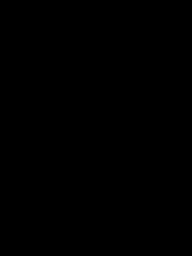

In [21]:
Image.fromarray(np.uint8(parse_pred_down[0][12] * 255))

In [22]:
parse.shape

torch.Size([1, 7, 1024, 768])

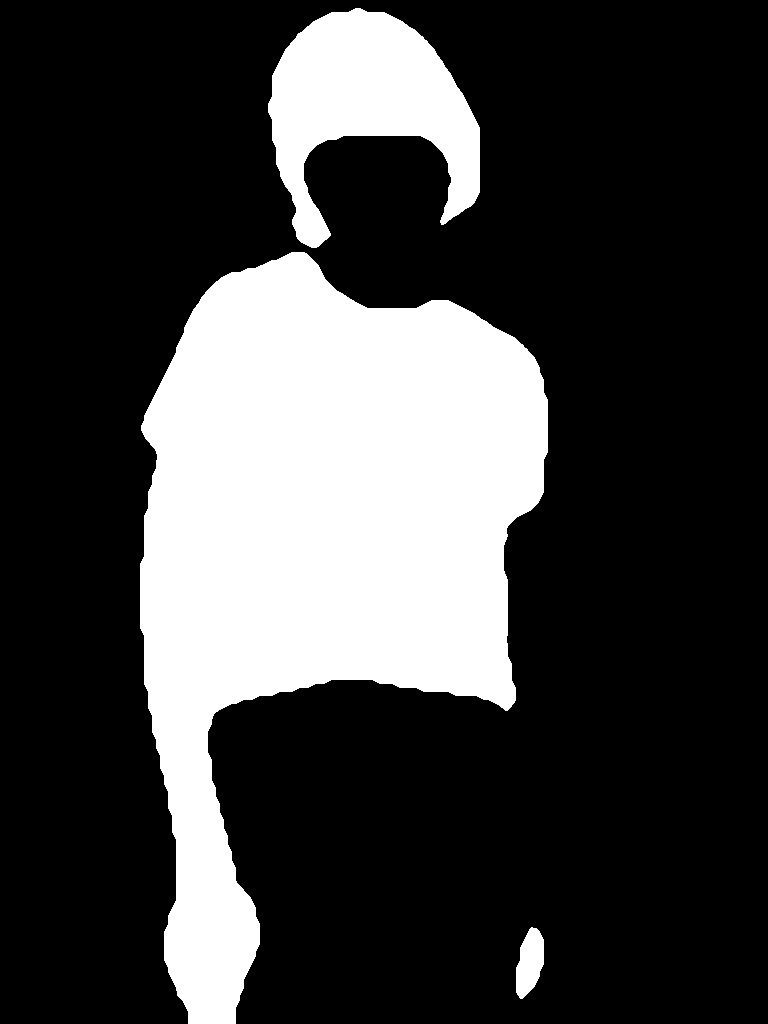

In [33]:
# 0:  ['background',  [0]],
# 1:  ['paste',       [2, 4, 7, 8, 9, 10, 11]],
# 2:  ['upper',       [3]],
# 3:  ['hair',        [1]],
# 4:  ['left_arm',    [5]],
# 5:  ['right_arm',   [6]],
# 6:  ['noise',       [12]]
seg_op = np.uint8(parse[0][2])
for i in range(3, 6):
    seg_op = seg_op + np.uint8(parse[0][i])
Image.fromarray(seg_op * 255)

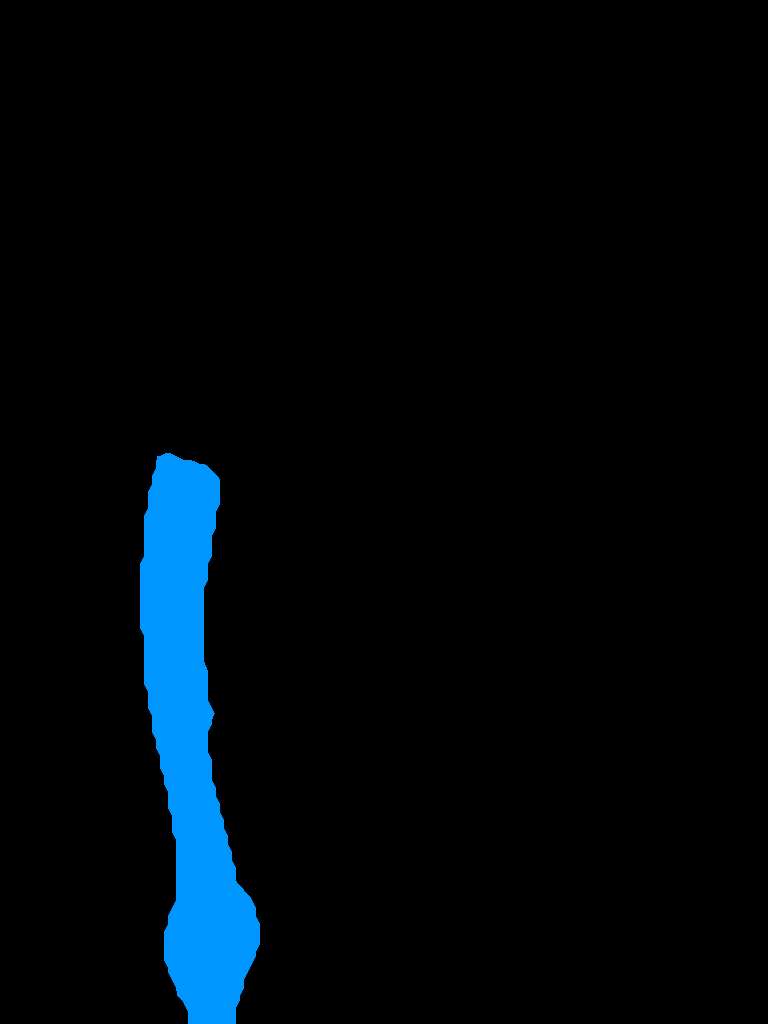

In [32]:
tmp_image = Image.fromarray(np.uint8(parse[0][5]) * 255)
rgb_image = tmp_image.convert("RGB")
red_color = (0, 150, 255)
for x in range(tmp_image.width):
    for y in range(tmp_image.height):
        pixel_value = tmp_image.getpixel((x, y))
        if pixel_value == 255:  # Assuming 255 represents the thresholded pixels (white)
            rgb_image.putpixel((x, y), red_color)
        else:
            rgb_image.putpixel((x, y), (0, 0, 0))  # Set non-thresholded pixels to black
rgb_image